### SHL github project: uat_shl

* training module: shl_tm

* prediction module: shl_pm

* simulation module: shl_sm

* misc module: shl_mm


### data feeds:

* historical bidding price, per second, time series

* live bidding price, per second, time series

### parameter lookup table: python dictionary

* parm_si (seasonality index per second)

* parm_month (parameter like alpha, beta, gamma, etc. per month)

# [1] Import useful reference packages

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

### Read raw data

In [3]:
df_history_ts_process = pd.read_csv('data/history_ts.csv') 
df_history_ts_process.tail()

,ccyy-mm,time,bid-price,ref-price
1886,2017-07,11:29:56,92100,89800
1887,2017-07,11:29:57,92100,89800
1888,2017-07,11:29:58,92100,89800
1889,2017-07,11:29:59,92200,89800
1890,2017-07,11:30:00,92200,89800


In [4]:
df_history_table_process = pd.read_csv('data/history_table.csv') 
df_history_table_process.tail()

,ccyy-mm,volume-plate,deal-price-low,deal-price-avg,deal-early-second,volume-bidder
26,2017-03,10356,87800,87916,55,262010
27,2017-04,12196,89800,89850,59,252273
28,2017-05,10316,90100,90209,55,270197
29,2017-06,10312,89400,89532,45,244349
30,2017-07,10325,92200,92250,57,269189


In [5]:
df_parm_si = pd.read_csv('data/parm_si.csv') 
# print(df_parm_si[(df_parm_si['ccyy-mm'] == '2017-07') & (df_parm_si['time'] == '11:29:00')].iloc[0]['si'])
df_parm_si.tail()

,ccyy-mm,time,si
2191,2017-12,11:29:56,1.0
2192,2017-12,11:29:57,1.0
2193,2017-12,11:29:58,1.0
2194,2017-12,11:29:59,1.0
2195,2017-12,11:30:00,1.0


In [6]:
df_parm_month = pd.read_csv('data/parm_month.csv') 
# print(df_parm_month[(df_parm_month['ccyy-mm'] == '2017-07') & (df_parm_month['time'] == '11:29:00')].iloc[0]['di'])
df_parm_month.tail()

,ccyy-mm,time,alpha,beta,gamma,sec57-weight,month-weight,short-weight,direction,di
67,2020-08,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
68,2020-09,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
69,2020-10,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
70,2020-11,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300
71,2020-12,11:29:00,0.5,0.5,0.5,0.5,0.9,0.125,-1,300


### Initialization

In [7]:
# function to fetch Seasonality-Index
def fetech_si(ccyy_mm, time, df_parm_si):
#     return df_parm_si[(df_parm_si['ccyy-mm'] == '2017-09') & (df_parm_si['time'] == '11:29:00')]
    return df_parm_si[(df_parm_si['ccyy-mm'] == ccyy_mm) & (df_parm_si['time'] == time)].iloc[0]['si']


In [8]:
# function to fetch Dynamic-Increment
def fetech_di(ccyy_mm, df_parm_month):
#     print(df_parm_month[df_parm_month['ccyy-mm'] == '2017-07'].iloc[0]['di'])
    return df_parm_month[df_parm_month['ccyy-mm'] == ccyy_mm].iloc[0]['di']


In [9]:
def get_previous_n_sec_time_as_str(df_time_field, n):
    return str((pd.to_datetime(df_time_field, format='%H:%M:%S') - pd.Timedelta(seconds=n)).time())
# print(get_previous_n_sec_time_as_str('11:29:57',3))

def get_future_n_sec_time_as_str(df_time_field, n):
    return str((pd.to_datetime(df_time_field, format='%H:%M:%S') - pd.Timedelta(seconds=-n)).time())
# print(get_future_n_sec_time_as_str('11:29:57',3))

### shl_sm Simulation Module Parm:

In [10]:
# which month to predict?
# global_parm_ccyy_mm = '2017-04'
# global_parm_ccyy_mm_offset = 1647

# global_parm_ccyy_mm = '2017-05'
# global_parm_ccyy_mm_offset = 1708

global_parm_ccyy_mm = '2017-06'
global_parm_ccyy_mm_offset = 1769

# global_parm_ccyy_mm = '2017-07'
# global_parm_ccyy_mm_offset = 1830



### shl_pm Prediction Module Parm:

  Global Parameters for Month : 2017-06
-------------------------------------------------
global_parm_dynamic_increment : 300
global_parm_alpha             : 0.777107313458705
global_parm_beta              : 0.179154416550987
global_parm_gamma             : 0.120598828573260
global_parm_sec57_weight      : 0.500000
global_parm_month_weight      : 0.900000
global_parm_short_weight      : 0.125000


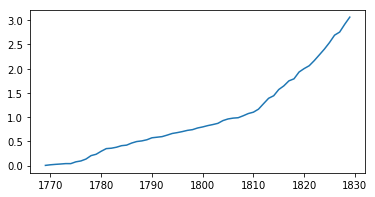

In [11]:
# create default global base price
global_parm_base_price = 10000000

global_parm_dynamic_increment = fetech_di(global_parm_ccyy_mm, df_parm_month)

global_parm_alpha = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['alpha']
global_parm_beta  = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['beta']
global_parm_gamma = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['gamma']
global_parm_sec57_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['sec57-weight']
global_parm_month_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['month-weight']
global_parm_short_weight = df_parm_month[df_parm_month['ccyy-mm'] == global_parm_ccyy_mm].iloc[0]['short-weight']

# create default average error between 46~50 seconds:
global_parm_short_weight_misc = 0

print('=================================================')
print('  Global Parameters for Month : %s' % global_parm_ccyy_mm)
print('-------------------------------------------------')

print('global_parm_dynamic_increment : %d' % global_parm_dynamic_increment)

print('global_parm_alpha             : %0.15f' % global_parm_alpha) # used in forecasting
print('global_parm_beta              : %0.15f' % global_parm_beta)  # used in forecasting
print('global_parm_gamma             : %0.15f' % global_parm_gamma) # used in forecasting
print('global_parm_sec57_weight      : %f' % global_parm_sec57_weight) # used in training a model
print('global_parm_month_weight      : %f' % global_parm_month_weight) # used in training a model
print('global_parm_short_weight      : %f' % global_parm_short_weight) # used in training a model
print('=================================================')

# plot seasonality index
plt.figure(figsize=(6,3))
plt.plot(df_parm_si[(df_parm_si['ccyy-mm'] == global_parm_ccyy_mm)]['si'])


# Start of shl_sm

In [12]:
# 11:29:00~11:29:50

global_parm_short_weight_misc = 0

# for i in range(1830, 1830+51): # use July 2015 data as simulatino
for i in range(global_parm_ccyy_mm_offset, global_parm_ccyy_mm_offset+51): # use July 2015 data as simulatino
    print('\n<<<< Record No.: %5d >>>>' % i)
    print(df_history_ts_process['ccyy-mm'][i]) # format: ccyy-mm
    print(df_history_ts_process['time'][i]) # format: hh:mm:ss
    print(df_history_ts_process['bid-price'][i]) # format: integer
#     print(df_history_ts_process['ref-price'][i])
    
    # capture & calculate 11:29:00 bid price - 1 = base price
    if df_history_ts_process['time'][i] == '11:29:00':
        global_parm_base_price = df_history_ts_process['bid-price'][i] -1 
        print('#### global_parm_base_price : %d ####' % global_parm_base_price)

        
    print('---- Pre-Process ---')
    # pre-process: ccyy-mm-hh:mm:ss
    f_actual_datetime = df_history_ts_process['ccyy-mm'][i] + ' ' + df_history_ts_process['time'][i]
    f_actual_price4pm = df_history_ts_process['bid-price'][i] -  global_parm_base_price
    print('#### f_actual_datetime   : %s ####' %  f_actual_datetime)
    print('#### f_actual_price4pm   : %d ####' % f_actual_price4pm)
    
    # get Seasonality-Index
    f_actual_si = fetech_si(df_history_ts_process['ccyy-mm'][i]
                                         ,df_history_ts_process['time'][i]
                                         ,df_parm_si)
    print('#### f_actual_si         : %0.10f ####' %  f_actual_si)
    f_1_step_si = fetech_si(df_history_ts_process['ccyy-mm'][i]
                                         ,df_history_ts_process['time'][i+1]
                                         ,df_parm_si)
    print('#### f_1_step_si         : %0.10f ####' %  f_1_step_si)
    # get de-seasoned price: price4pmsi
    f_actual_price4pmsi = f_actual_price4pm / f_actual_si
    print('#### f_actual_price4pmsi : %0.10f ####' % f_actual_price4pmsi)
    


    if df_history_ts_process['time'][i] == '11:29:00':
        df_shl_pm = pd.DataFrame() # initialize prediction dataframe at 11:29:00
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        f_1_step_pred_les_level = f_actual_price4pmsi
        f_1_step_pred_les_trend = 0
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        f_1_step_pred_les_misc = 0
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment
        f_current_step_pred_les = f_1_step_pred_les
        f_current_step_pred_les_misc = f_1_step_pred_les_misc
        f_current_step_pred_price_inc = f_1_step_pred_price_inc
        f_current_step_pred_price = f_1_step_pred_price
        f_current_step_pred_price_rounded = f_1_step_pred_price_rounded
        f_current_step_pred_dynamic_increment = f_1_step_pred_dynamic_increment # +200 or + 300
        f_current_step_pred_set_price_rounded = f_1_step_pred_set_price_rounded
        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
    else:
        previous_time = get_previous_n_sec_time_as_str(df_history_ts_process['time'][i], 1)
        previous_pred_les_level = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_level']
        print('     previous_pred_les_level : %f' % previous_pred_les_level)
        
        previous_pred_les_trend = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_trend']
        print('     previous_pred_les_trend : %f' % previous_pred_les_trend)
        
        f_current_step_pred_les = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les']
        f_current_step_pred_les_misc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_misc']
        f_current_step_pred_price_inc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_inc']
        f_current_step_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price']
        f_current_step_pred_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_rounded']
        f_current_step_pred_dynamic_increment = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_dynamic_increment']
        f_current_step_pred_set_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_set_price_rounded']

        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
            
        if df_history_ts_process['time'][i] == '11:29:50':
            # function to get average forecast error between 46~50 seconds: mean(f_current_step_error)
            global_parm_short_weight_misc = (df_shl_pm.iloc[46:50]['f_current_step_error'].sum() \
                                             + f_current_step_error) / 5
            print('#### global_parm_short_weight_misc : %f' % global_parm_short_weight_misc)
            
#         call predicitno functino shl_pm, forcaste next k=1 step
        print('---- call predicitno function shl_pm ---- %s' % df_history_ts_process['time'][i])
        
        f_1_step_pred_les_level = global_parm_alpha * f_actual_price4pmsi \
                                    + (1 - global_parm_alpha) * (previous_pred_les_level + previous_pred_les_trend)
        print('     f_1_step_pred_les_level  : %f' % f_1_step_pred_les_level)
        f_1_step_pred_les_trend = global_parm_beta * (f_1_step_pred_les_level - previous_pred_les_level) \
                                    + (1 - global_parm_beta) * previous_pred_les_trend
        print('     f_1_step_pred_les_trend  : %f' % f_1_step_pred_les_trend)
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        
        f_1_step_pred_les_misc = global_parm_short_weight_misc * global_parm_short_weight * global_parm_gamma
        
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment
   
        
    # write results to shl_pm dataframe
            
    df_shl_pm_current = {
                         'ccyy-mm' : df_history_ts_process['ccyy-mm'][i]
                        ,'time' : df_history_ts_process['time'][i]
                        ,'bid' : df_history_ts_process['bid-price'][i]
                        ,'datetime' : f_actual_datetime
                        ,'f_actual_price4pm' : f_actual_price4pm
                        ,'f_actual_si' : f_actual_si
                        ,'f_1_step_si' : f_1_step_si
                        ,'f_actual_price4pmsi' :  f_actual_price4pmsi
                        ,'f_1_step_pred_les_level' : f_1_step_pred_les_level
                        ,'f_1_step_pred_les_trend' : f_1_step_pred_les_trend
                        ,'f_1_step_pred_les' : f_1_step_pred_les
                        ,'f_1_step_pred_les_misc' : f_1_step_pred_les_misc
                        ,'f_1_step_pred_price_inc' : f_1_step_pred_price_inc
                        ,'f_1_step_pred_price' : f_1_step_pred_price
                        ,'f_1_step_pred_price_rounded' : f_1_step_pred_price_rounded
                        ,'f_1_step_pred_dynamic_increment' : f_1_step_pred_dynamic_increment # +200 or + 300
                        ,'f_1_step_pred_set_price_rounded' : f_1_step_pred_set_price_rounded
                        ,'f_current_step_pred_les' : f_current_step_pred_les
                        ,'f_current_step_pred_les_misc' : f_current_step_pred_les_misc
                        ,'f_current_step_pred_price_inc' : f_current_step_pred_price_inc
                        ,'f_current_step_pred_price' : f_current_step_pred_price
                        ,'f_current_step_pred_price_rounded' : f_current_step_pred_price_rounded
                        ,'f_current_step_pred_dynamic_increment' : f_current_step_pred_dynamic_increment # +200 or + 300
                        ,'f_current_step_pred_set_price_rounded' : f_current_step_pred_set_price_rounded
                        ,'f_current_step_error' : f_current_step_error
                        }
    df_shl_pm =  df_shl_pm.append(df_shl_pm_current, ignore_index=True)



<<<< Record No.:  1769 >>>>
2017-06
11:29:00
88400
#### global_parm_base_price : 88399 ####
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:00 ####
#### f_actual_price4pm   : 1 ####
#### f_actual_si         : 0.0023822130 ####
#### f_1_step_si         : 0.0148610890 ####
#### f_actual_price4pmsi : 419.7777444754 ####
---- call predicitno function shl_pm ---- 11:29:00

<<<< Record No.:  1770 >>>>
2017-06
11:29:01
88500
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:01 ####
#### f_actual_price4pm   : 101 ####
#### f_actual_si         : 0.0148610890 ####
#### f_1_step_si         : 0.0237690550 ####
#### f_actual_price4pmsi : 6796.2717940792 ####
     previous_pred_les_level : 419.777744
     previous_pred_les_trend : 0.000000
---- call predicitno function shl_pm ---- 11:29:01
     f_1_step_pred_les_level  : 5374.997905
     f_1_step_pred_les_trend  : 887.749577

<<<< Record No.:  1771 >>>>
2017-06
11:29:02
88500
---- Pre-Process ---
#### f_actual_datetime   :

     previous_pred_les_level : 216.534618
     previous_pred_les_trend : -99.176657
---- call predicitno function shl_pm ---- 11:29:16
     f_1_step_pred_les_level  : 212.738673
     f_1_step_pred_les_trend  : -82.088781

<<<< Record No.:  1786 >>>>
2017-06
11:29:17
88500
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:17 ####
#### f_actual_price4pm   : 101 ####
#### f_actual_si         : 0.4638547580 ####
#### f_1_step_si         : 0.4951657820 ####
#### f_actual_price4pmsi : 217.7405712846 ####
     previous_pred_les_level : 212.738673
     previous_pred_les_trend : -82.088781
---- call predicitno function shl_pm ---- 11:29:17
     f_1_step_pred_les_level  : 198.328696
     f_1_step_pred_les_trend  : -69.963824

<<<< Record No.:  1787 >>>>
2017-06
11:29:18
88500
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:18 ####
#### f_actual_price4pm   : 101 ####
#### f_actual_si         : 0.4951657820 ####
#### f_1_step_si         : 0.5080609120 ####
#### f_actual_p

<<<< Record No.:  1802 >>>>
2017-06
11:29:33
88800
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:33 ####
#### f_actual_price4pm   : 401 ####
#### f_actual_si         : 0.8456485560 ####
#### f_1_step_si         : 0.8708946860 ####
#### f_actual_price4pmsi : 474.1922600764 ####
     previous_pred_les_level : 493.996373
     previous_pred_les_trend : 10.320051
---- call predicitno function shl_pm ---- 11:29:33
     f_1_step_pred_les_level  : 480.906716
     f_1_step_pred_les_trend  : 6.126098

<<<< Record No.:  1803 >>>>
2017-06
11:29:34
88800
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:34 ####
#### f_actual_price4pm   : 401 ####
#### f_actual_si         : 0.8708946860 ####
#### f_1_step_si         : 0.9278569940 ####
#### f_actual_price4pmsi : 460.4460291769 ####
     previous_pred_les_level : 480.906716
     previous_pred_les_trend : 6.126098
---- call predicitno function shl_pm ---- 11:29:34
     f_1_step_pred_les_level  : 466.372029
     f_1_step_pre

<<<< Record No.:  1818 >>>>
2017-06
11:29:49
89100
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:49 ####
#### f_actual_price4pm   : 701 ####
#### f_actual_si         : 1.7903136450 ####
#### f_1_step_si         : 1.9309782790 ####
#### f_actual_price4pmsi : 391.5515038149 ####
     previous_pred_les_level : 407.754317
     previous_pred_les_trend : -5.963580
---- call predicitno function shl_pm ---- 11:29:49
     f_1_step_pred_les_level  : 393.833754
     f_1_step_pred_les_trend  : -7.389108

<<<< Record No.:  1819 >>>>
2017-06
11:29:50
89100
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:50 ####
#### f_actual_price4pm   : 701 ####
#### f_actual_si         : 1.9309782790 ####
#### f_1_step_si         : 2.0018259430 ####
#### f_actual_price4pmsi : 363.0284232731 ####
     previous_pred_les_level : 393.833754
     previous_pred_les_trend : -7.389108
#### global_parm_short_weight_misc : 45.827121
---- call predicitno function shl_pm ---- 11:29:50
     f_1_st

In [13]:
# df_shl_pm.iloc[2]
df_shl_pm.head()

,bid,ccyy-mm,datetime,f_1_step_pred_dynamic_increment,f_1_step_pred_les,f_1_step_pred_les_level,f_1_step_pred_les_misc,f_1_step_pred_les_trend,f_1_step_pred_price,f_1_step_pred_price_inc,...,f_actual_si,f_current_step_error,f_current_step_pred_dynamic_increment,f_current_step_pred_les,f_current_step_pred_les_misc,f_current_step_pred_price,f_current_step_pred_price_inc,f_current_step_pred_price_rounded,f_current_step_pred_set_price_rounded,time
0,88400.0,2017-06,2017-06 11:29:00,300.0,419.777744,419.777744,0.0,0.000000,88405.238354,6.238354,...,0.002382,5.238354,300.0,419.777744,0.0,88405.238354,6.238354,88400.0,88700.0,11:29:00
1,88500.0,2017-06,2017-06 11:29:01,300.0,6262.747481,5374.997905,0.0,887.749577,88547.859589,148.859589,...,0.014861,-94.761646,300.0,419.777744,0.0,88405.238354,6.238354,88400.0,88700.0,11:29:01
2,88500.0,2017-06,2017-06 11:29:02,300.0,5305.444549,4698.022384,0.0,607.422165,88563.168196,164.168196,...,0.023769,47.859589,300.0,6262.747481,0.0,88547.859589,148.859589,88500.0,88800.0,11:29:02
3,88500.0,2017-06,2017-06 11:29:03,300.0,4042.258206,3719.046295,0.0,323.211911,88557.505465,158.505465,...,0.030943,63.168196,300.0,5305.444549,0.0,88563.168196,164.168196,88600.0,88900.0,11:29:03
4,88500.0,2017-06,2017-06 11:29:04,300.0,3021.651634,2902.612317,0.0,119.039317,88516.146201,117.146201,...,0.039212,57.505465,300.0,4042.258206,0.0,88557.505465,158.505465,88600.0,88900.0,11:29:04


In [14]:
df_shl_pm.tail()

,bid,ccyy-mm,datetime,f_1_step_pred_dynamic_increment,f_1_step_pred_les,f_1_step_pred_les_level,f_1_step_pred_les_misc,f_1_step_pred_les_trend,f_1_step_pred_price,f_1_step_pred_price_inc,...,f_actual_si,f_current_step_error,f_current_step_pred_dynamic_increment,f_current_step_pred_les,f_current_step_pred_les_misc,f_current_step_pred_price,f_current_step_pred_price_inc,f_current_step_pred_price_rounded,f_current_step_pred_set_price_rounded,time
46,89100.0,2017-06,2017-06 11:29:46,300.0,457.874298,455.163705,0.000000,2.710593,89152.141453,753.141453,...,1.569456,59.936033,300.0,484.840699,0.0,89159.936033,760.936033,89200.0,89500.0,11:29:46
47,89100.0,2017-06,2017-06 11:29:47,300.0,431.537674,433.240360,0.000000,-1.702686,89153.510464,754.510464,...,1.644865,52.141453,300.0,457.874298,0.0,89152.141453,753.141453,89200.0,89500.0,11:29:47
48,89100.0,2017-06,2017-06 11:29:48,300.0,401.790737,407.754317,0.000000,-5.963580,89118.331439,719.331439,...,1.748423,53.510464,300.0,431.537674,0.0,89153.510464,754.510464,89200.0,89500.0,11:29:48
49,89100.0,2017-06,2017-06 11:29:49,300.0,386.444646,393.833754,0.000000,-7.389108,89145.216217,746.216217,...,1.790314,18.331439,300.0,401.790737,0.0,89118.331439,719.331439,89100.0,89400.0,11:29:49
50,89100.0,2017-06,2017-06 11:29:50,300.0,357.598562,368.247728,0.690837,-10.649166,89116.233014,717.233014,...,1.930978,45.216217,300.0,386.444646,0.0,89145.216217,746.216217,89100.0,89400.0,11:29:50


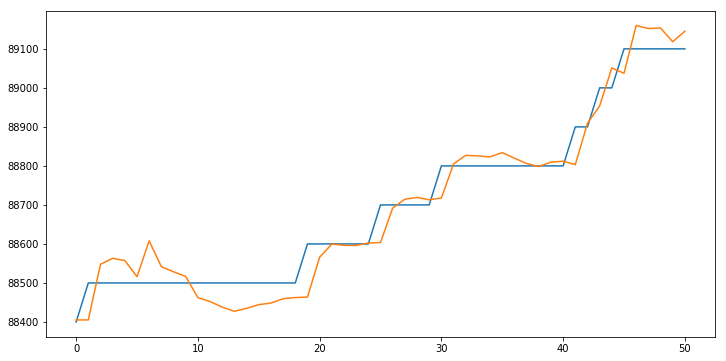

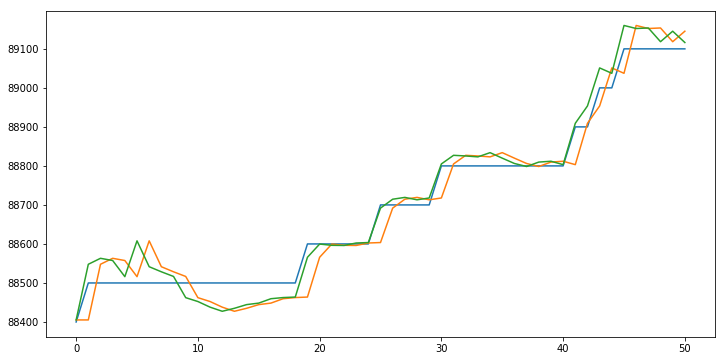

In [15]:
plt.figure(figsize=(12,6))
plt.plot(df_shl_pm['bid'])
plt.plot(df_shl_pm['f_current_step_pred_price'])
# plt.plot(df_shl_pm['f_1_step_pred_price'].shift(1))

plt.figure(figsize=(12,6))
plt.plot(df_shl_pm['bid'])
plt.plot(df_shl_pm['f_current_step_pred_price'])
plt.plot(df_shl_pm['f_1_step_pred_price'])


### Start of prediction module: shl_pm

In [16]:
# 11:29:51~
def predict_k_step_price(df_shl_pm, ccyy_mm, time, k):
    print('month & time  : ', ccyy_mm, time)
    print()
    
#     df_shl_pm_k = pd.DataFrame() # initialize prediction dataframe
    for sec in range(0, k):
        
        
        print('delta second(s) : ', sec)
        current_time  = get_future_n_sec_time_as_str(time, sec)
        print('current_time  : %s' % current_time)
        f_1_step_time  = get_future_n_sec_time_as_str(current_time, 1)
        print('f_1_step_time  : %s' % f_1_step_time)
        previous_time = get_previous_n_sec_time_as_str(current_time, 1)
        print('previous_time : %s' % previous_time)

        previous_pred_les_level = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_level']
        print('     previous_pred_les_level : %f' % previous_pred_les_level)
        
        previous_pred_les_trend = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_trend']
        print('     previous_pred_les_trend : %f' % previous_pred_les_trend)


        print('---- Pre-Process ---')
        ############ use predicted value for boost-trap
        previous_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == global_parm_ccyy_mm) \
                                            & (df_shl_pm['time'] == previous_time)].iloc[0]['f_1_step_pred_price']
        # pre-process: ccyy-mm-hh:mm:ss
        f_actual_datetime = global_parm_ccyy_mm + ' ' + current_time
#         f_actual_price4pm = df_history_ts_process['bid-price'][i] -  global_parm_base_price
        f_actual_price4pm = previous_pred_price -  global_parm_base_price
        print('#### f_actual_datetime   : %s ####' %  f_actual_datetime)
        print('#### previous_pred_price: %s ####' %  previous_pred_price)
        print('#### f_actual_price4pm   : %d ####' % f_actual_price4pm)

        # get Seasonality-Index
        f_actual_si = fetech_si(global_parm_ccyy_mm
                                             ,current_time
                                             ,df_parm_si)
        try:
            f_1_step_si = fetech_si(global_parm_ccyy_mm
                                                 ,f_1_step_time
                                                 ,df_parm_si)
        except:
            f_1_step_si = fetech_si(global_parm_ccyy_mm
                                                 ,current_time
                                                 ,df_parm_si)            

        print('#### f_actual_si         : %0.10f ####' %  f_actual_si)
        # get de-seasoned price: price4pmsi
        f_actual_price4pmsi = f_actual_price4pm / f_actual_si
        print('#### f_actual_price4pmsi : %0.10f ####' % f_actual_price4pmsi)

        f_current_step_pred_les = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les']
        f_current_step_pred_les_misc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_les_misc']
        f_current_step_pred_price_inc = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_inc']
        f_current_step_pred_price = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price']
        f_current_step_pred_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_price_rounded']
        f_current_step_pred_dynamic_increment = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_dynamic_increment']
        f_current_step_pred_set_price_rounded = df_shl_pm[(df_shl_pm['ccyy-mm'] == df_history_ts_process['ccyy-mm'][i]) \
                                                    & (df_shl_pm['time'] ==previous_time)].iloc[0]['f_1_step_pred_set_price_rounded']
        
        f_current_step_error = f_current_step_pred_price_inc - f_actual_price4pm # current second forecast error
        

        f_1_step_pred_les_level = global_parm_alpha * f_actual_price4pmsi \
                                    + (1 - global_parm_alpha) * (previous_pred_les_level + previous_pred_les_trend)
        print('     f_1_step_pred_les_level  : %f' % f_1_step_pred_les_level)
        f_1_step_pred_les_trend = global_parm_beta * (f_1_step_pred_les_level - previous_pred_les_level) \
                                    + (1 - global_parm_beta) * previous_pred_les_trend
        print('     f_1_step_pred_les_trend  : %f' % f_1_step_pred_les_trend)
        f_1_step_pred_les = f_1_step_pred_les_level + f_1_step_pred_les_trend
        
#         f_1_step_pred_les_misc = 0
        f_1_step_pred_les_misc = global_parm_short_weight_misc * global_parm_short_weight * (sec+2) * global_parm_gamma
        
#         f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_actual_si
        f_1_step_pred_price_inc = (f_1_step_pred_les + f_1_step_pred_les_misc) * f_1_step_si
        f_1_step_pred_price = f_1_step_pred_price_inc + global_parm_base_price
        f_1_step_pred_price_rounded = round(f_1_step_pred_price/100, 0) * 100
        f_1_step_pred_dynamic_increment = global_parm_dynamic_increment
        f_1_step_pred_set_price_rounded = f_1_step_pred_price_rounded + f_1_step_pred_dynamic_increment 

#         write results to shl_pm dataframe
        df_shl_pm_current = {
                             'ccyy-mm' : global_parm_ccyy_mm
                            ,'time' : current_time
                            ,'bid' : previous_pred_price
                            ,'datetime' : f_actual_datetime
                            ,'f_actual_price4pm' : f_actual_price4pm
                            ,'f_actual_si' : f_actual_si
                            ,'f_1_step_si' : f_1_step_si
                            ,'f_actual_price4pmsi' :  f_actual_price4pmsi
                            ,'f_1_step_pred_les_level' : f_1_step_pred_les_level
                            ,'f_1_step_pred_les_trend' : f_1_step_pred_les_trend
                            ,'f_1_step_pred_les' : f_1_step_pred_les
                            ,'f_1_step_pred_les_misc' : f_1_step_pred_les_misc
                            ,'f_1_step_pred_price_inc' : f_1_step_pred_price_inc
                            ,'f_1_step_pred_price' : f_1_step_pred_price
                            ,'f_1_step_pred_price_rounded' : f_1_step_pred_price_rounded
                            ,'f_1_step_pred_dynamic_increment' : f_1_step_pred_dynamic_increment # +200 or + 300
                            ,'f_1_step_pred_set_price_rounded' : f_1_step_pred_set_price_rounded
                            ,'f_current_step_pred_les' : f_current_step_pred_les
                            ,'f_current_step_pred_les_misc' : f_current_step_pred_les_misc
                            ,'f_current_step_pred_price_inc' : f_current_step_pred_price_inc
                            ,'f_current_step_pred_price' : f_current_step_pred_price
                            ,'f_current_step_pred_price_rounded' : f_current_step_pred_price_rounded
                            ,'f_current_step_pred_dynamic_increment' : f_current_step_pred_dynamic_increment # +200 or + 300
                            ,'f_current_step_pred_set_price_rounded' : f_current_step_pred_set_price_rounded
                            ,'f_current_step_error' : f_current_step_error
                            }
        print('---------------------------')
        df_shl_pm =  df_shl_pm.append(df_shl_pm_current, ignore_index=True)
        
    return df_shl_pm

In [17]:
df_shl_pm_k_step = predict_k_step_price(df_shl_pm, global_parm_ccyy_mm, '11:29:51', 10)

month & time  :  2017-06 11:29:51

delta second(s) :  0
current_time  : 11:29:51
f_1_step_time  : 11:29:52
previous_time : 11:29:50
     previous_pred_les_level : 368.247728
     previous_pred_les_trend : -10.649166
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:51 ####
#### previous_pred_price: 89116.2330136 ####
#### f_actual_price4pm   : 717 ####
#### f_actual_si         : 2.0018259430 ####
#### f_actual_price4pmsi : 358.2893988020 ####
     f_1_step_pred_les_level  : 358.135416
     f_1_step_pred_les_trend  : -10.552987
---------------------------
delta second(s) :  1
current_time  : 11:29:52
f_1_step_time  : 11:29:53
previous_time : 11:29:51
     previous_pred_les_level : 358.135416
     previous_pred_les_trend : -10.552987
---- Pre-Process ---
#### f_actual_datetime   : 2017-06 11:29:52 ####
#### previous_pred_price: 89118.1595185 ####
#### f_actual_price4pm   : 719 ####
#### f_actual_si         : 2.0608409580 ####
#### f_actual_price4pmsi : 348.9641040323 ####
   

In [18]:
df_shl_pm_k_step['f_current_step_pred_les_misc'].tail(11)

50    0.000000
51    0.690837
52    1.381674
53    2.072511
54    2.763349
55    3.454186
56    4.145023
57    4.835860
58    5.526697
59    6.217534
60    6.908371
Name: f_current_step_pred_les_misc, dtype: float64

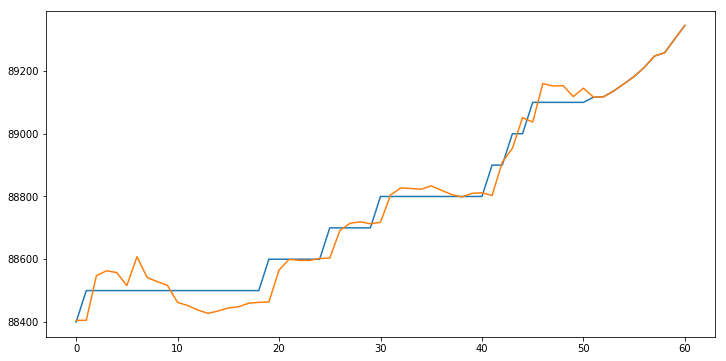

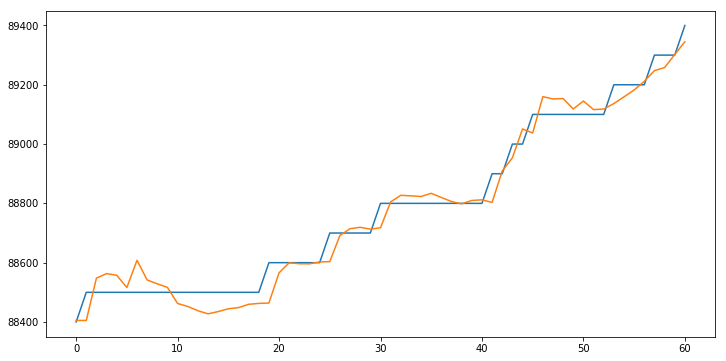

In [19]:
# bid is predicted bid-price from shl_pm
plt.figure(figsize=(12,6))
plt.plot(df_shl_pm_k_step['bid'])
# plt.plot(df_shl_pm_k_step['f_1_step_pred_price'].shift(1))
plt.plot(df_shl_pm_k_step['f_current_step_pred_price'])

# bid is actual bid-price from raw dataset
df_actual_bid = df_history_ts_process[global_parm_ccyy_mm_offset:global_parm_ccyy_mm_offset+61].copy()
df_actual_bid.reset_index(inplace=True)
plt.figure(figsize=(12,6))
plt.plot(df_actual_bid['bid-price'])
# plt.plot(df_shl_pm_k_step['f_1_step_pred_price'].shift(1))
plt.plot(df_shl_pm_k_step['f_current_step_pred_price'])
# plt.plot(df_shl_pm_k_step['bid'])


### End of prediction module: shl_pm

In [20]:
# actual price & oredicted price & error
pd.concat([df_actual_bid['bid-price'].tail(11), df_shl_pm_k_step['f_current_step_pred_price'].tail(11), df_shl_pm_k_step['f_current_step_pred_price'].tail(11) - df_actual_bid['bid-price'].tail(11)], axis=1, join='inner')


,bid-price,f_current_step_pred_price,0
50,89100,89145.216217,45.216217
51,89100,89116.233014,16.233014
52,89100,89118.159518,18.159518
53,89200,89136.554118,-63.445882
54,89200,89159.145618,-40.854382
55,89200,89182.469462,-17.530538
56,89200,89211.444759,11.444759
57,89300,89247.611095,-52.388905
58,89300,89257.998994,-42.001006
59,89300,89301.800158,1.800158


In [21]:
df_shl_pm_k_step.iloc[57]
# df_shl_pm_k_step.iloc[50:61]

bid                                               89247.6
ccyy-mm                                           2017-06
datetime                                 2017-06 11:29:57
f_1_step_pred_dynamic_increment                       300
f_1_step_pred_les                                 306.165
f_1_step_pred_les_level                           314.122
f_1_step_pred_les_misc                             5.5267
f_1_step_pred_les_trend                          -7.95613
f_1_step_pred_price                                 89258
f_1_step_pred_price_inc                           858.999
f_1_step_pred_price_rounded                         89300
f_1_step_pred_set_price_rounded                     89600
f_1_step_si                                       2.75592
f_actual_price4pm                                 848.611
f_actual_price4pmsi                               315.199
f_actual_si                                        2.6923
f_current_step_error                          4.77485e-12
f_current_step


# End of shl_sm

---

### The End